###setup

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
import numpy as np
import pandas as pd
import pickle
import random
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
path='/content/drive/MyDrive/fake-news-adversarial-benchmark/'
# Define paths liar
"""
dataset='LIAR'
model_path = path+'Model/liar_model2'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/liar/'
path_csv= path_data_created+'liar_1000.csv'
shap_path=path_data_created+'shapvalues_1000_liar.sav'
path_labels=path_data_created+'labels_liar.npy'
outputs_path=path_data_created+'original_probs_liar_1000.pt'
"""
# Define paths Fake News

dataset='Fake News'
model_path = path+'Model/fn_model'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/fake_news/'
path_csv= path_data_created+'fake_news_1000.csv'
path_labels=path_data_created+'labels_fake_news.npy'
shap_path=path_data_created+'shapvalues_1000_fake_news.sav'
outputs_path=path_data_created+'original_outputs_fake_news_1000.pt'
"""
# Define paths imdb

dataset='IMDB'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'
path_csv= path_data_created+'imdb_1000.csv'
path_labels=path_data_created+'labels_imdb.npy'
shap_path=path_data_created+'shapvalues_1000_imdb.sav'
outputs_path=path_data_created+'original_probs_imdb_1000.pt'
"""

"\n# Define paths imdb\n\ndataset='IMDB'\npath_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'\npath_csv= path_data_created+'imdb_1000.csv'\npath_labels=path_data_created+'labels_imdb.npy'\nshap_path=path_data_created+'shapvalues_1000_imdb.sav' \noutputs_path=path_data_created+'original_probs_imdb_1000.pt'\n"

In [ ]:
path_final=path+'final_files/'+dataset+'/'
path_perturbed=path_data_created+'perturbed/'

In [ ]:
perturbed_texts= np.load(path_perturbed+dataset+'_all_perturbed.npy', allow_pickle=True)
#original_shaps= pickle.load(open(path_perturbed+dataset+'_all_perturbed_original_shap.sav', 'rb'))
ind= np.load(path_perturbed+dataset+'_all_perturbed_ind.npy', allow_pickle=True)
df = pd.read_csv(path_csv)
original_probs= torch.load(outputs_path, map_location=torch.device('cpu'))
"""
original_shaps = []
for i in ind:
  original_shaps.append(shap_values[i])
  """

'\noriginal_shaps = []\nfor i in ind:\n  original_shaps.append(shap_values[i])\n  '

In [ ]:
# Load the tokenizer and model
if dataset == 'IMDB':
  print('Using IMDB trained model and Tokenizer')
  !pip install textattack
  tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
  model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-imdb")
else:
  print('Using '+str(model_path)+' model')
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  model = BertForSequenceClassification.from_pretrained(model_path,  num_labels = 2)

Using /content/drive/MyDrive/fake-news-adversarial-benchmark/Model/fn_model model


In [ ]:
lipschitz_sample = df.iloc[ind]['statement'].copy().tolist()
lipschitz_sample[:10]

['20 wines for under $20: the fall edition - the new york times',
 'have the dallas police improved? depends on whom you ask - the new york times',
 'how we can win the propaganda war',
 'russian grannies make deal with lipton',
 'counter terror police arrest man carrying axe, knives near uk army base',
 "swedish pensioner prosecuted for 'hate' for accusing migrants of arson",
 'broad challenge to trump order may center on cleveland doctor - the new york times',
 'marks and spencer to turn high street stores into bingo halls',
 'texas elector expects massive corruption related to the electoral college vote',
 'hundreds of pounds lighter, and now shedding another burden of the past - the new york times']

In [ ]:
print(perturbed_texts[0][:10])
print(lipschitz_sample[0])


['000 wines for under $20: the fall edition - the new york times'
 '1 wines for under $20: the fall edition - the new york times'
 '10 wines for under $20: the fall edition - the new york times'
 '100 wines for under $20: the fall edition - the new york times'
 '15 wines for under $20: the fall edition - the new york times'
 '1920 wines for under $20: the fall edition - the new york times'
 '2 wines for under $20: the fall edition - the new york times'
 '20 and for under $20: the fall edition - the new york times'
 '20 bordeaux for under $20: the fall edition - the new york times'
 '20 bottles for under $20: the fall edition - the new york times']
20 wines for under $20: the fall edition - the new york times


In [ ]:
random.seed(42)
for sublist in perturbed_texts:
    random.shuffle(sublist)
perturbed_texts[0][:10]

array(['20 wines for under $20: the fall edition - the financial york times',
       '20 wines for under $20: the fall edition - the new baltimore times',
       '20 wines for under $r: the fall edition - the new york times',
       '20 wines for under $20: the fall edition - top new york times',
       '20 and for under $20: the fall edition - the new york times',
       '20 wines found under $20: the fall edition - the new york times',
       '20 wines worth under $20: the fall edition - the new york times',
       '20 wines only under $20: the fall edition - the new york times',
       '20 wines for under $20: the next edition - the new york times',
       '20 wines for under $20: the fall edition - the new herald times'],
      dtype='<U70')

###definitions

In [ ]:
def filter_token(tokens):
  mask = np.logical_and(tokens != 101, tokens != 102)
  mask = np.logical_and(mask, tokens != 0)
  return tokens[mask]

def decode_tokens(tokens):
  string = tokenizer.decode(tokens)
  return string

def filter_decode_tokens(tokens):
  mask = np.logical_and(tokens != 101, tokens != 102)
  mask = np.logical_and(mask, tokens != 0)
  string = tokenizer.decode(tokens[mask])
  return string

In [ ]:
def local_lipschitz_torch(original_exp, perturbed_exp, distance):
    # this function is set up to do individual (non-batched) calculations for pytorch tensors
    return torch.norm(original_exp - perturbed_exp).item() / distance

def local_lipschitz(original_exp, perturbed_exp, distance):
    # original_exp (# features) - perturbed_exps (# neighbors, # features) will broadcast across neighbors
    # --- note: this assumes that the perturbed_exp array represents as many documents as input_distances (for the division by distance)
    # taking L2 norm over axis=-1 will return the L2 norm for each perturbed neighbor
    # divide by euclidean distances for each neighbor to get a vector of (# neighbors)
    return np.linalg.norm(original_exp - perturbed_exp, axis=-1) / np.array(distance)

In [ ]:
def indices_below_threshold(nested_list, threshold, count_amount=35):
    indices = []
    count=[]
    index=[]
    for i, sublist in enumerate(nested_list):
      count_per_list=0
      indices_per_list = []
      for j, value in enumerate(sublist):
          if value < threshold:
              indices_per_list.append(j)
              count_per_list+=1
      indices.append(indices_per_list)
      count.append(count_per_list)
      if count_per_list > count_amount:
        index.append(i)
    return index, indices

###check distance to determine EPSILON

In [ ]:
d = np.load(path_perturbed+dataset+'_distances.npy', allow_pickle=True)

In [ ]:
sample_distances_index_75, ind_75 = indices_below_threshold(d, 0.75, 15)
len(sample_distances_index_75)

###lipschitz read

In [ ]:
lip_fake=  np.load('/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/fake_news/perturbed/Fake News_119_lipschitz.npy')

In [ ]:
lip_liar=np.load('/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/liar/perturbed/threshhold_75/LIAR_53_lipschitz.npy')

In [ ]:
np.max(lip_liar)

4.807995635213863

In [ ]:
np.max(lip_fake)

0.7236797789179109

In [ ]:

def box_plot_template(data, ylabel, legend, filename, title, xlabel, x_ax_range=None, y_ax_range=None, colors=None):
  plt.figure(figsize=(11.69, 8.27))
  if colors is None:
    colors = ['#ff0051', '#008bfb', '#2cb32c']
  if len(data) != len(legend):
    raise ValueError("The number of lines to be plotted must match the length of the legend list.")
  for i, d in enumerate(data):
    plt.boxplot(d, positions=[i], widths=0.6, showfliers=True, patch_artist=True,
                boxprops=dict(
                facecolor='white',
                edgecolor='black'),
                medianprops=dict(color=colors[i%len(colors)], linewidth=1.5),
                flierprops=dict(markeredgecolor=colors[i%len(colors)]#, alpha=0.25
                                ),
               # whiskerprops=dict(color=colors[i%len(colors)]),
               # capprops=dict(color=colors[i%len(colors)])
                )
    #plt.boxplot(d, positions=[i], widths=0.6, showfliers=True, patch_artist=False, medianprops=dict(color=colors[i%len(colors)], linewidth=2))
  plt.rcParams["font.family"] = "Arial"
  plt.xlim(x_ax_range)
  plt.ylim(y_ax_range)
  plt.xticks(range(len(data)), legend , fontsize=14)
  plt.title(title, fontsize=16)
  #plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.grid(visible=True, which='both', axis='both', linestyle='--', color='gainsboro')
  plt.savefig((path_data_created+filename), dpi=300, bbox_inches='tight')
  plt.show()

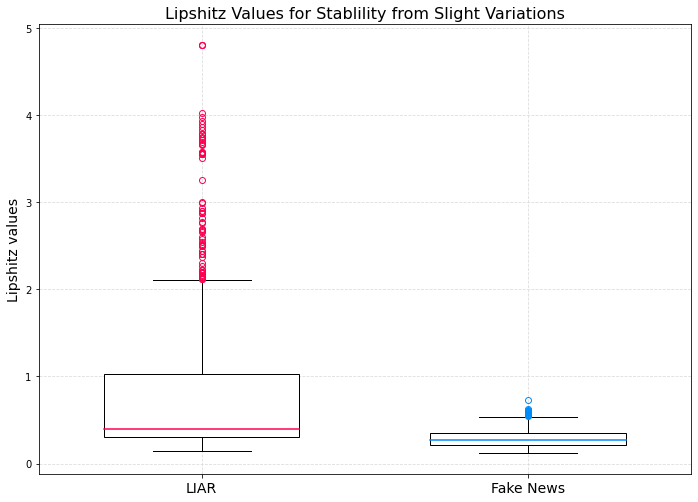

In [ ]:
data = [ lip_liar.flatten(), lip_fake.flatten()]
legend = ['LIAR','Fake News']
ylabel = 'Lipshitz values'
filename = 'lip.png'
title = 'Lipshitz Values for Stablility from Slight Variations'
xlabel = 'x'
box_plot_template(data, ylabel, legend, filename, title, xlabel, x_ax_range=None, y_ax_range=None, colors=None)

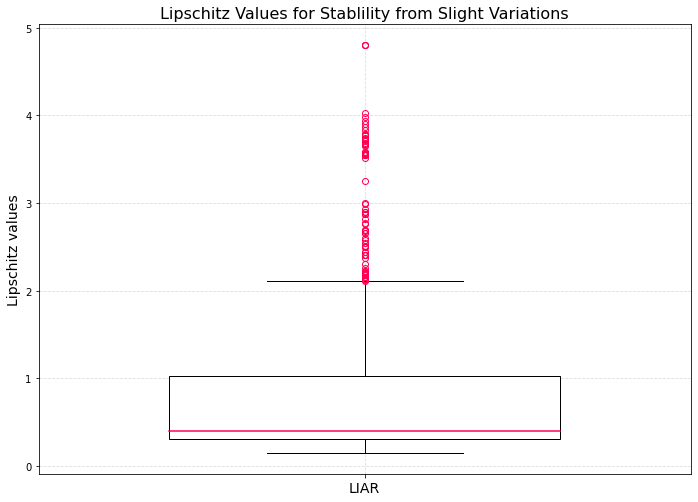

In [ ]:
data = [lip_liar.flatten()]
legend = ['LIAR']
ylabel = 'Lipschitz values'
filename = 'lip_liar.png'
title = 'Lipschitz Values for Stablility from Slight Variations'
xlabel = 'LIAR'
box_plot_template(data, ylabel, legend, filename, title, xlabel, x_ax_range=None, y_ax_range=None, colors=None)

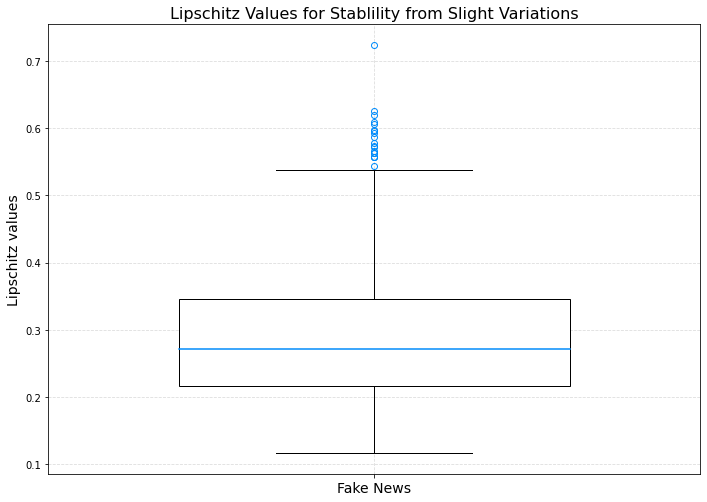

In [ ]:
data = [lip_fake.flatten()]
legend = ['Fake News']
ylabel = 'Lipschitz values'
filename = 'lip_fn.png'
title = 'Lipschitz Values for Stablility from Slight Variations'
xlabel = 'Fake News'
box_plot_template(data, ylabel, legend, filename, title, xlabel, x_ax_range=None, y_ax_range=None, colors=['#008bfb'])

In [ ]:
max_lipschitz_values_fake= [[[0.30507083]], [[0.30507083]], [[0.30507083]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.59711427]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]], [[0.72367978]]]

In [ ]:
len(max_lipschitz_values_fake)

34

In [ ]:
lip_fake_copy =[[[0.25242121]], [[0.28359173]], [[0.24200837]], [[0.2523111]], [[0.28538414]], [[0.2629174]], [[0.27937538]], [[0.30360927]], [[0.23257492]], [[0.30507083]], [[0.28461292]], [[0.28382915]], [[0.28520258]], [[0.26257269]], [[0.23095266]], [[0.21121012]], [[0.20598456]], [[0.19683233]], [[0.21447387]], [[0.21915563]], [[0.22423122]], [[0.24988208]], [[0.2613545]], [[0.20743233]], [[0.18616883]], [[0.21347073]], [[0.20869692]], [[0.20334541]], [[0.21498308]], [[0.21577436]], [[0.24789083]], [[0.27666321]], [[0.27204806]], [[0.27637517]], [[0.28347855]], [[0.29746087]], [[0.2593808]], [[0.2878182]], [[0.25869491]], [[0.24896277]], [[0.29627787]], [[0.26348619]], [[0.24472228]], [[0.2673534]], [[0.25030578]], [[0.40795878]], [[0.54334738]], [[0.40723437]], [[0.45654852]], [[0.46434368]], [[0.43316813]], [[0.40339838]], [[0.50281911]], [[0.45060915]], [[0.39363706]], [[0.4112104]], [[0.47121064]], [[0.59711427]], [[0.39973531]], [[0.51890869]], [[0.25698308]], [[0.27077072]], [[0.2161115]], [[0.19263138]], [[0.23492823]], [[0.24647839]], [[0.19719109]], [[0.21827835]], [[0.2432863]], [[0.26026075]], [[0.27470844]], [[0.25480233]], [[0.22948043]], [[0.29633266]], [[0.26193622]], [[0.20458786]], [[0.24795948]], [[0.20523377]], [[0.21531785]], [[0.20660596]], [[0.20117209]], [[0.22532773]], [[0.21054132]], [[0.19618136]], [[0.20697122]], [[0.22124007]], [[0.20912356]], [[0.20170454]], [[0.20077367]], [[0.19873257]], [[0.25116242]], [[0.33582605]], [[0.35264012]], [[0.2674206]], [[0.29885126]], [[0.35667898]], [[0.38434088]], [[0.28787848]], [[0.3026959]], [[0.29722068]], [[0.29629661]], [[0.34399948]], [[0.25388852]], [[0.24583523]], [[0.30435086]], [[0.25378363]], [[0.24896277]], [[0.26122676]], [[0.31564303]], [[0.2494867]], [[0.3631931]], [[0.24684671]], [[0.26771961]], [[0.2930212]], [[0.25030578]], [[0.26708294]], [[0.27204806]], [[0.24872063]], [[0.2376777]], [[0.26745221]], [[0.23603737]], [[0.35582553]], [[0.3639836]], [[0.36812819]], [[0.34110047]], [[0.38167833]], [[0.34470287]], [[0.38380103]], [[0.37079981]], [[0.38801453]], [[0.38473857]], [[0.44161499]], [[0.41038525]], [[0.36115142]], [[0.3870823]], [[0.29759404]], [[0.32464711]], [[0.3543506]], [[0.29184795]], [[0.29140237]], [[0.35678752]], [[0.30081972]], [[0.32399448]], [[0.34811612]], [[0.32445538]], [[0.33955726]], [[0.39265875]], [[0.34359372]], [[0.39026966]], [[0.29473541]], [[0.28024429]], [[0.26400036]], [[0.31063136]], [[0.29478071]], [[0.33186875]], [[0.29383834]], [[0.31011037]], [[0.27907256]], [[0.26858264]], [[0.25593542]], [[0.28632586]], [[0.32165568]], [[0.27218469]], [[0.28107017]], [[0.28943105]], [[0.31927405]], [[0.35474574]], [[0.31947883]], [[0.25704099]], [[0.35232319]], [[0.29958091]], [[0.40087205]], [[0.3005586]], [[0.29201589]], [[0.30225197]], [[0.22829082]], [[0.32324185]], [[0.26530572]], [[0.28608691]], [[0.29224938]], [[0.20227882]], [[0.2408888]], [[0.21802366]], [[0.22325669]], [[0.17747258]], [[0.164721]], [[0.2597843]], [[0.1787822]], [[0.23484491]], [[0.16600334]], [[0.23099053]], [[0.18528677]], [[0.22592614]], [[0.24729448]], [[0.24717355]], [[0.35240078]], [[0.34743298]], [[0.38664554]], [[0.3472074]], [[0.40034509]], [[0.38091018]], [[0.38420832]], [[0.43220325]], [[0.34102388]], [[0.34492037]], [[0.35323881]], [[0.35205999]], [[0.35551208]], [[0.37293067]], [[0.35997004]], [[0.33117551]], [[0.31055923]], [[0.23857097]], [[0.25809982]], [[0.3453627]], [[0.30401472]], [[0.23393843]], [[0.2511983]], [[0.29531201]], [[0.2865705]], [[0.29514563]], [[0.22682271]], [[0.25597549]], [[0.22581312]], [[0.28005823]], [[0.57243452]], [[0.56306753]], [[0.5717894]], [[0.55717143]], [[0.53271129]], [[0.53368866]], [[0.59557938]], [[0.62519426]], [[0.58698711]], [[0.59276975]], [[0.72367978]], [[0.53563728]], [[0.6053984]], [[0.57721598]], [[0.53028257]], [[0.3407574]], [[0.27603297]], [[0.26964235]], [[0.34331124]], [[0.27427446]], [[0.27776347]], [[0.28436843]], [[0.27583398]], [[0.29907205]], [[0.30880884]], [[0.27359348]], [[0.32301574]], [[0.27541147]], [[0.27902952]], [[0.37922831]], [[0.43771797]], [[0.47057346]], [[0.48175137]], [[0.43605673]], [[0.43563717]], [[0.45923662]], [[0.42702309]], [[0.47077403]], [[0.4302186]], [[0.49840871]], [[0.43511926]], [[0.43458677]], [[0.55613016]], [[0.46692285]], [[0.46229903]], [[0.2494867]], [[0.26348619]], [[0.26249161]], [[0.26745221]], [[0.26939457]], [[0.25030578]], [[0.25129125]], [[0.31564303]], [[0.25943156]], [[0.25060303]], [[0.27666321]], [[0.25378363]], [[0.26771961]], [[0.3631931]], [[0.34097652]], [[0.39074917]], [[0.31803521]], [[0.33139524]], [[0.30326124]], [[0.36611644]], [[0.30969004]], [[0.26909492]], [[0.31994025]], [[0.37407469]], [[0.3600581]], [[0.39589276]], [[0.33074739]], [[0.27494296]], [[0.38013049]], [[0.4632851]], [[0.22656954]], [[0.18792829]], [[0.20931459]], [[0.16857322]], [[0.17651927]], [[0.24089355]], [[0.16300348]], [[0.21261039]], [[0.18351517]], [[0.20667117]], [[0.2090418]], [[0.18057521]], [[0.16242767]], [[0.21034775]], [[0.17574256]], [[0.22009247]], [[0.22783399]], [[0.23028607]], [[0.1810634]], [[0.21723812]], [[0.22898215]], [[0.20846575]], [[0.20913484]], [[0.19355321]], [[0.16119287]], [[0.16351916]], [[0.1753559]], [[0.15546054]], [[0.19246904]], [[0.22117358]], [[0.43511926]], [[0.49840871]], [[0.45271773]], [[0.47077403]], [[0.43771797]], [[0.55613016]], [[0.46618111]], [[0.46229903]], [[0.42878068]], [[0.48801573]], [[0.46692285]], [[0.42702309]], [[0.48175137]], [[0.46872475]], [[0.4302186]], [[0.27861689]], [[0.31830773]], [[0.24913641]], [[0.24941126]], [[0.29216993]], [[0.26024393]], [[0.31582984]], [[0.28143615]], [[0.31339509]], [[0.25907225]], [[0.29828096]], [[0.28302584]], [[0.26546603]], [[0.27111594]], [[0.28119135]], [[0.34209576]], [[0.29812081]], [[0.35043401]], [[0.26969086]], [[0.28868037]], [[0.2814242]], [[0.26904971]], [[0.33388008]], [[0.31432161]], [[0.34282538]], [[0.30820679]], [[0.26621161]], [[0.2723875]], [[0.26235617]], [[0.34674222]], [[0.15633488]], [[0.15254628]], [[0.18796061]], [[0.14378475]], [[0.16582454]], [[0.17854611]], [[0.193848]], [[0.13526843]], [[0.19957581]], [[0.14708929]], [[0.17239388]], [[0.16963734]], [[0.14911324]], [[0.16547906]], [[0.14613208]], [[0.27188323]], [[0.27537598]], [[0.25650275]], [[0.25201466]], [[0.24427535]], [[0.27083158]], [[0.25609037]], [[0.25291453]], [[0.31791077]], [[0.29289689]], [[0.26720087]], [[0.28954783]], [[0.26216777]], [[0.37259119]], [[0.24376484]], [[0.23705432]], [[0.22541856]], [[0.22109368]], [[0.21537931]], [[0.21483363]], [[0.26331748]], [[0.27499965]], [[0.23069455]], [[0.22544471]], [[0.21334952]], [[0.22055156]], [[0.22241564]], [[0.17389046]], [[0.22244633]], [[0.23201483]], [[0.12273277]], [[0.12614747]], [[0.14889116]], [[0.13419124]], [[0.16041726]], [[0.12286922]], [[0.14588954]], [[0.21415378]], [[0.14427517]], [[0.13127878]], [[0.12743899]], [[0.11925249]], [[0.14508179]], [[0.11646348]], [[0.13920237]], [[0.2062301]], [[0.2121405]], [[0.20527391]], [[0.19643721]], [[0.19331746]], [[0.22862246]], [[0.20181566]], [[0.20742482]], [[0.20608415]], [[0.2442527]], [[0.20189215]], [[0.20254483]], [[0.20241256]], [[0.24210651]], [[0.21082186]], [[0.17651927]], [[0.21261039]], [[0.20931459]], [[0.20667117]], [[0.21034775]], [[0.17574256]], [[0.16242767]], [[0.22656954]], [[0.18351517]], [[0.2090418]], [[0.16857322]], [[0.18792829]], [[0.24089355]], [[0.16300348]], [[0.18057521]], [[0.13445935]], [[0.15431304]], [[0.1506463]], [[0.17119007]], [[0.16077147]], [[0.15759446]], [[0.19163303]], [[0.1565719]], [[0.19771036]], [[0.15099207]], [[0.1670824]], [[0.14826703]], [[0.12726694]], [[0.17556762]], [[0.21009842]], [[0.44005068]], [[0.41919497]], [[0.61899573]], [[0.56241108]], [[0.43957945]], [[0.43443471]], [[0.51592033]], [[0.48975014]], [[0.53763167]], [[0.52447202]], [[0.56505586]], [[0.45068588]], [[0.60847125]], [[0.50860907]], [[0.4206373]], [[0.25508212]], [[0.25717078]], [[0.41833747]], [[0.30681988]], [[0.28081473]], [[0.26224684]], [[0.37912176]], [[0.34136913]], [[0.25593542]], [[0.28107017]], [[0.46470861]], [[0.32357291]], [[0.29478071]], [[0.30066965]], [[0.37455255]]]

In [ ]:
np.max(lip)

0.72367978

In [ ]:
len(lip)/34

15.0

In [ ]:
np.min(lip_liar)

0.14266143557660382

In [ ]:
len(lip_liar)/15

34.0

###discover lipshitz values

In [ ]:
pd.DataFrame(lip_fake.flatten()).describe()

,0
count,510.000000
mean,0.293863
std,0.106869
min,0.116463
25%,0.216393
50%,0.270801
75%,0.346397
max,0.723680


In [ ]:
pd.DataFrame(lip_liar.flatten()).describe()

,0
count,510.000000
mean,0.952215
std,1.043909
min,0.142661
25%,0.309840
50%,0.399083
75%,1.029362
max,4.807996


In [ ]:
sorted_index_array = np.argsort(llf)

# sorted array
sorted_array = llf[sorted_index_array]

In [ ]:
sorted_array[-20:]

array([3.67129161, 3.67129161, 3.69057029, 3.71155447, 3.7362693 ,
       3.74558438, 3.77836525, 3.780344  , 3.780344  , 3.78386733,
       3.78386733, 3.83340391, 3.86657006, 3.8975115 , 3.93509706,
       3.98061891, 4.02288051, 4.80799564, 4.80799564, 4.80799564])

In [ ]:
sorted(sorted_index_array[-20:])

[336,
 345,
 348,
 350,
 352,
 355,
 356,
 359,
 361,
 362,
 363,
 364,
 365,
 367,
 368,
 369,
 370,
 371,
 373,
 374]

In [ ]:
374/15

24.933333333333334

In [ ]:
llf= lip_liar.flatten()

In [ ]:
lip_fake.flatten()

In [ ]:
d = np.load(path_perturbed+dataset+'_distances.npy', allow_pickle=True)

###label flip

In [ ]:
texts=[]
distances=[]
indices=[]
i_position=[]
j_posittion=[]
for n, i in enumerate(sample_distances_index_75):
 for m, j in enumerate(ind_75[i]):
   if d[i][j] > 0:
    print(perturbed_texts[i][j])
    print(d[i][j])
    print(ind[i])
    print(j)
    texts.append(perturbed_texts[i][j])
    distances.append(d[i][j])
    indices.append(ind[i])
    i_position.append(i)
    j_position.append(j)


In [ ]:
df_d=pd.DataFrame({'texts': texts, 'distances': distances, 'indices': indices, 'i_position': i_position, 'j_position': j_position})

In [ ]:
df_d

,texts,distances,indices,i_position,j_posittion
0,30 wines for under $20: the fall edition - the...,0.592961,102,0,10
1,20 wines for under $10: the fall edition - the...,0.615482,102,0,11
2,20 wines for under $50: the fall edition - the...,0.717636,102,0,40
3,20 wines for under $40: the fall edition - the...,0.694263,102,0,42
4,20 wines for under $25: the fall edition - the...,0.612094,102,0,49
...,...,...,...,...,...
1877,.cciag 2.0 issues alert for hackers to indepen...,0.729446,729,119,451
1878,guccifer 2.0 issues alert for hackers to indep...,0.627681,729,119,466
1879,guccifer 2.0 issues alert for hackeridea to in...,0.636871,729,119,475
1880,guccifer 2.0 issues alert for hackers to indep...,0.731276,729,119,476


In [ ]:
distances

In [ ]:
def compute_flip(df_d, tokenizer, model, original_prob, device):
    ind_flip=[]
    pos_i=[]
    pos_j=[]
    en_df=encode_df(df_d['texts'], tokenizer)
    with torch.no_grad():
      model.to(device)
      p_selected = model(en_df['input_ids'].to(device),
                         attention_mask=en_df['attention_masks'].to(device))

    for i in range(len(df_d)):
        x_selected = p_selected[i].cpu()
        prob = original_prob[df_d['indices']].cpu()
        print(i)
        if np.argmax(prob)==np.argmax(x_selected) == False:
          print('indices' + str(indices),+ 'i_p' +str(df_d['i_position']) +'j_p' +str(df_d['j_position'])  )
          ind_flip.append(df_d['indices'])
          pos_i.append(df_d['i_position'])
          pos_j.append(df_d['j_position'])
    return pd.DataFrame({'ind_flip': ind_flip, 'pos_i': pos_i,  'pos_j': pos_j})


In [ ]:
def encode_df(data, tokenizer):
    bert_encoded_dict = data.apply(lambda sent: tokenizer.encode_plus(
                      sent,
                      add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                      max_length = 120,           # Pad & truncate all sentences.
                      padding='max_length',
                      return_attention_mask = True,   # Construct attn. masks.
                      return_tensors = 'pt',     # Return pytorch tensors.
                      truncation = True
                      ))
    bert_input_ids = torch.cat([item['input_ids'] for item in bert_encoded_dict], dim=0)
    bert_attention_masks = torch.cat([item['attention_mask'] for item in bert_encoded_dict], dim=0)
    return {'input_ids':bert_input_ids, 'attention_masks':bert_attention_masks}

In [ ]:
res= compute_flip(df_d, tokenizer, model, original_probs, device)

0


IndexError: ignored

In [ ]:
ind_flip=[]
pos_i=[]
pos_j=[]
en_df=encode_df(df_d['texts'], tokenizer)
with torch.no_grad():
  model.to(device)
  p_selected = model(en_df['input_ids'].to(device),
                      attention_mask=en_df['attention_masks'].to(device))

for i in range(len(df_d)):
    x_selected = p_selected[0][i].cpu()
    prob = original_probs[df_d['indices']].cpu()
    print(i)
    if np.argmax(prob)==np.argmax(x_selected) == False:
      print('indices' + str(indices)+ 'i_p' +str(df_d['i_position']) +'j_p' +str(df_d['j_position'])  )
      ind_flip.append(df_d['indices'])
      pos_i.append(df_d['i_position'])
      pos_j.append(df_d['j_position'])
df_dd= pd.DataFrame({'ind_flip': ind_flip, 'pos_i': pos_i,  'pos_j': pos_j})

0


TypeError: ignored

In [ ]:
import torch.nn.functional as F
probs_selected=F.softmax(p_selected.logits, dim=1)
probs_original= F.softmax(original_probs, dim=1)
ind_flip=[]
pos_i=[]
pos_j=[]
for i in range(len(df_d)):
    x_selected = probs_selected[i].cpu() #probs_selected[0][i].cpu()
    prob = probs_original[df_d['indices'][i]].cpu()
   # print(i)
    if (torch.argmax(prob)==torch.argmax(x_selected)) == False:
      print(prob)
      print(x_selected)
      print(torch.argmax(prob))
      print(torch.argmax(x_selected))
      print(i)
      print('indices' + str(df_d['indices'].iloc[i])+ 'i_p' +str(df_d['i_position'].iloc[i]) +'j_p' +str(df_d['j_position'].iloc[i])  )
      ind_flip.append(df_d['indices'].iloc[i])
      pos_i.append(df_d['i_position'].iloc[i])
      pos_j.append(df_d['j_position'].iloc[i])

df_dd= pd.DataFrame({'ind_flip': ind_flip, 'pos_i': pos_i,  'pos_j': pos_j})

tensor([9.9998e-01, 1.7245e-05])
tensor([0.4858, 0.5142])
tensor(0)
tensor(1)
46
indices871i_p9j_p95
tensor([9.9998e-01, 1.7245e-05])
tensor([3.6780e-05, 9.9996e-01])
tensor(0)
tensor(1)
71
indices871i_p9j_p287
tensor([9.9998e-01, 1.7245e-05])
tensor([0.2593, 0.7407])
tensor(0)
tensor(1)
78
indices871i_p9j_p377
tensor([9.9998e-01, 1.7245e-05])
tensor([0.0093, 0.9907])
tensor(0)
tensor(1)
94
indices871i_p9j_p493
tensor([9.9998e-01, 1.7245e-05])
tensor([0.0369, 0.9631])
tensor(0)
tensor(1)
101
indices871i_p9j_p547
tensor([9.9998e-01, 1.7245e-05])
tensor([0.0130, 0.9870])
tensor(0)
tensor(1)
105
indices871i_p9j_p570
tensor([9.9998e-01, 1.7245e-05])
tensor([3.8980e-05, 9.9996e-01])
tensor(0)
tensor(1)
107
indices871i_p9j_p592
tensor([9.9998e-01, 1.7245e-05])
tensor([6.5607e-05, 9.9993e-01])
tensor(0)
tensor(1)
113
indices871i_p9j_p632
tensor([9.9998e-01, 1.5946e-05])
tensor([5.8800e-04, 9.9941e-01])
tensor(0)
tensor(1)
134
indices474i_p12j_p262
tensor([9.9998e-01, 1.5946e-05])
tensor([0.03

In [ ]:
len(df_dd)

56

In [ ]:
df_dd['ind_flip'].unique()

In [ ]:
df_dd['ind_flip']==871

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8     False
9     False
10    False
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27     True
28     True
29     True
30     True
31     True
32     True
33     True
34     True
35     True
36     True
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
Name: ind_flip, dtype: bool